In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.svm import SVC
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE

When working on this project, we found several intuitive correlations to be incorrect. This may be due to how the DoT reports weather delays, as minor weather delays are part of the NAS delay category and major weather delays for the weather delay category. To correct this, we often create a new column combining these two catagories. 

Another problem with the dataset is that it is imbalanced. This means that the number of delays is much smaller than the number of on-time flights. This can lead to a model that is biased towards predicting on-time flights, even though delayed flights would be much more important. Each airport has around a 10% delay rate, so we will need to balance the dataset to get a more accurate model.

In [97]:
# for every airline, get the corresponding airport data from the cleaned flight data
# and save it in a new csv file

origins_folder = '../data/origins'

for origin in os.listdir(origins_folder):

    data_frame = pd.read_csv(os.path.join(origins_folder, origin))
    weather_delay_count = ((data_frame['WeatherDelay'] > 0) | (data_frame['NASDelay'] > 0)).sum()
    percent_true = (weather_delay_count / len(data_frame)) * 100
    
    # Print the percent true, formatted to two decimal places
    print(f'{origin}: {percent_true:.2f}%')

ATL.csv: 9.35%
AUS.csv: 9.79%
BNA.csv: 9.92%
BOS.csv: 12.91%
BWI.csv: 11.48%
CLT.csv: 11.90%
DCA.csv: 12.30%
DEN.csv: 11.63%
DFW.csv: 12.47%
DTW.csv: 9.21%
EWR.csv: 13.81%
FLL.csv: 17.39%
IAD.csv: 11.55%
IAH.csv: 10.41%
JFK.csv: 13.73%
LAS.csv: 12.89%
LAX.csv: 8.21%
LGA.csv: 11.46%
MCO.csv: 17.58%
MDW.csv: 12.06%
MIA.csv: 16.46%
MSP.csv: 10.53%
ORD.csv: 12.53%
PHL.csv: 13.34%
PHX.csv: 7.54%
SAN.csv: 9.59%
SEA.csv: 10.37%
SFO.csv: 6.64%
SLC.csv: 8.74%
TPA.csv: 11.37%


The two target features that appeared to have the most correlation with our weather data was a boolean value for if the flight was canceled due to weather, and combining the NAS and weather delay columns to create a new column for if the flight was delayed due to weather. We will be using these two target features to train our model.

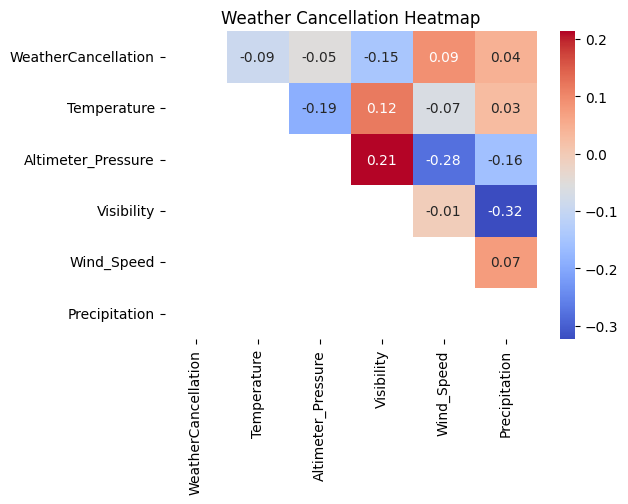

In [38]:
data = pd.read_csv('../data/origins/BOS.csv')
data['WeatherCancellation'] = data['CancellationReason'] == 'Weather'
data.drop(columns=['Time','Origin','Dest','Carrier','Cancelled','CancellationReason','CarrierDelay', 'Sea_Level_Pressure','SecurityDelay',
                   'LateAircraftDelay', 'Feels_Like_Temperature', 'Wind_Gust', 'Delayed', 'Ice_Accretion_3hr', 'DepDelayMinutes', 'WeatherDelay', 'NASDelay'], inplace=True)

columns_order = ['WeatherCancellation', 'Temperature', 'Altimeter_Pressure', 'Visibility', 'Wind_Speed', 'Precipitation']

data = data[columns_order]

correlation_matrix = data.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Weather Cancellation Heatmap')
plt.show()

In [40]:
X = data.drop(columns=['WeatherCancellation'])
y = data['WeatherCancellation']

# Assuming X is your feature matrix and y is your target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create and train the model with class weights
model = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]})
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.92      0.96     84952
        True       0.13      0.70      0.21      1337

    accuracy                           0.92     86289
   macro avg       0.56      0.81      0.58     86289
weighted avg       0.98      0.92      0.95     86289



In [39]:
X = data.drop(columns=['WeatherCancellation'])
y = data['WeatherCancellation']

# Assuming X is your feature matrix and y is your target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.97      0.98     84952
        True       0.22      0.58      0.32      1337

    accuracy                           0.96     86289
   macro avg       0.61      0.78      0.65     86289
weighted avg       0.98      0.96      0.97     86289



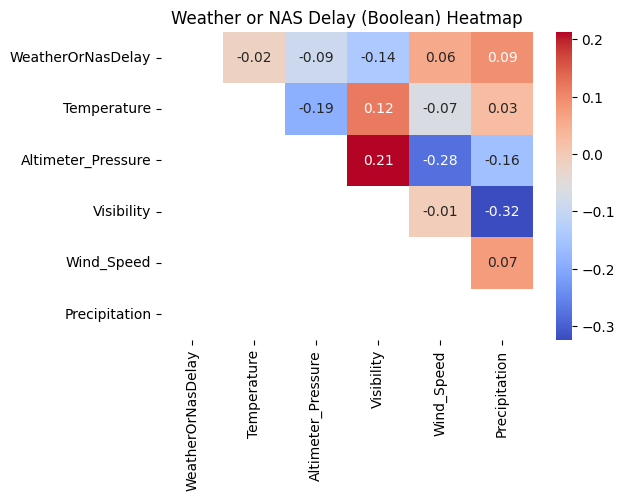

In [32]:
data = pd.read_csv('../data/origins/BOS.csv')

data['WeatherOrNasDelay'] = (data['WeatherDelay'] > 0) | (data['NASDelay'] > 0)

data.drop(columns=['Time','Origin','Dest','Carrier','Cancelled','CancellationReason','CarrierDelay', 'Sea_Level_Pressure','SecurityDelay',
                   'LateAircraftDelay', 'Feels_Like_Temperature', 'Wind_Gust', 'Delayed', 'Ice_Accretion_3hr', 'DepDelayMinutes', 'WeatherDelay', 'NASDelay'], inplace=True)

columns_order = ['WeatherOrNasDelay', 'Temperature', 'Altimeter_Pressure', 'Visibility', 'Wind_Speed', 'Precipitation']

data = data[columns_order]

correlation_matrix = data.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Weather or NAS Delay (Boolean) Heatmap')
plt.show()

In [33]:
X = data.drop(columns=['WeatherOrNasDelay'])
y = data['WeatherOrNasDelay']

# Assuming X is your feature matrix and y is your target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create and train the model with class weights
model = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]})
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.75      0.83     75045
        True       0.26      0.59      0.36     11244

    accuracy                           0.73     86289
   macro avg       0.59      0.67      0.60     86289
weighted avg       0.84      0.73      0.77     86289



In [34]:
X = data.drop(columns=['WeatherOrNasDelay'])
y = data['WeatherOrNasDelay']

# Assuming X is your feature matrix and y is your target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      0.82      0.87     75045
        True       0.30      0.51      0.38     11244

    accuracy                           0.78     86289
   macro avg       0.61      0.67      0.62     86289
weighted avg       0.84      0.78      0.80     86289



# Get only the rows where there is a weather or nas delay, and predict the value on that instead.

Before: rmse: 27.6
After: rmse: 19.4

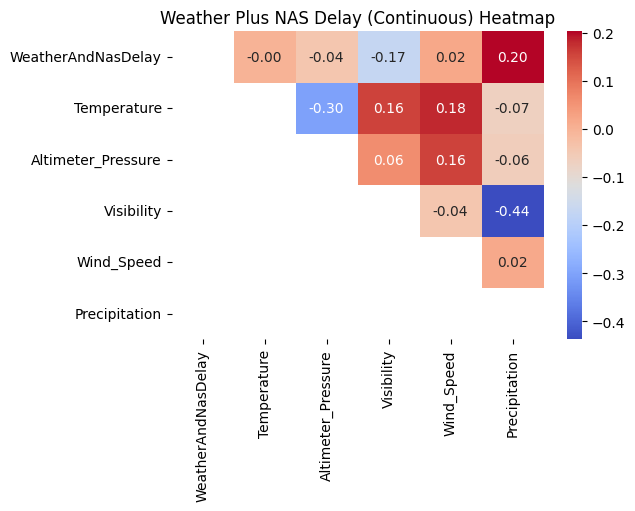

In [84]:
data = pd.read_csv('../data/origins/MIA.csv')

data = data[(data['WeatherDelay'] != 0) & (data['NASDelay'] != 0)]

data['WeatherDelay'] = data['WeatherDelay'].fillna(0)
data['NASDelay'] = data['NASDelay'].fillna(0)

data['WeatherAndNasDelay'] = data['WeatherDelay'] + data['NASDelay']

data.drop(columns=['Time','Origin','Dest','Carrier','Cancelled','CancellationReason','CarrierDelay', 'Sea_Level_Pressure','SecurityDelay',
                   'LateAircraftDelay', 'Feels_Like_Temperature', 'Wind_Gust', 'Delayed', 'Ice_Accretion_3hr', 'DepDelayMinutes', 'WeatherDelay', 'NASDelay'], inplace=True)

columns_order = ['WeatherAndNasDelay', 'Temperature', 'Altimeter_Pressure', 'Visibility', 'Wind_Speed', 'Precipitation']

data = data[columns_order]

correlation_matrix = data.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Weather Plus NAS Delay (Continuous) Heatmap')
plt.show()

In [85]:
X = data.drop(columns=['WeatherAndNasDelay'])
y = data['WeatherAndNasDelay']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 19.403532978849505


C:\Users\wipar\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


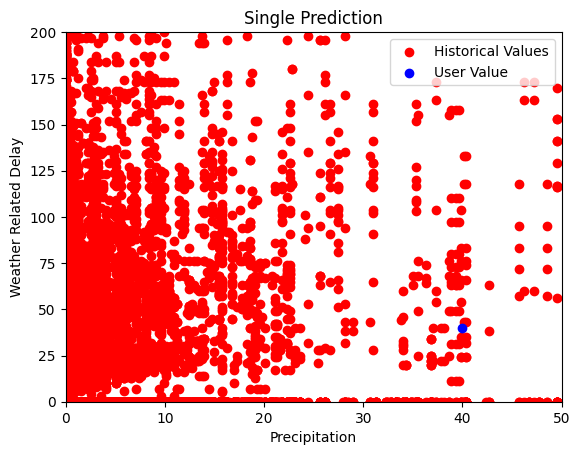

In [86]:
X_single = data.drop('WeatherAndNasDelay', axis=1)
X_true = [data['WeatherAndNasDelay']]
X_axis = [data['Precipitation']]

# Make prediction for the single data point
predicted_value = model.predict(X_single)

# Plotting
plt.scatter(X_axis, X_true, color='red', label='Historical Values')
plt.scatter(40, 40, color='blue', label='User Value')
plt.xlabel('Precipitation')
plt.ylabel('Weather Related Delay')
plt.title('Single Prediction')
plt.xlim(0, 50)
plt.ylim(0, 200)
plt.legend()
plt.show()

In [ ]:
X = data.drop(columns=['WeatherAndNasDelay'])
y = data['WeatherAndNasDelay']

# Assuming X is your feature matrix and y is your target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Compute class weights
sample_weights = compute_sample_weight('balanced', y_train)

# Create and train the model with class weights
model = RandomForestClassifier(class_weight={0: class_weights[0], 1: class_weights[1]})
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 762.5986470111941


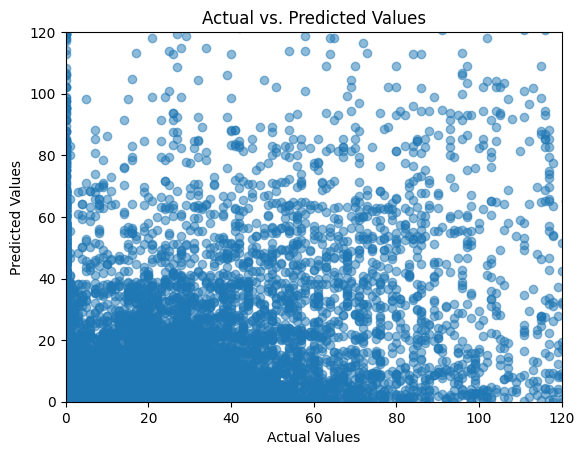

In [93]:
# plt.hexbin(y_test, predictions, gridsize=100, cmap='Blues', bins='log')
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.xlim(0, 120)  # Limit x-axis range
plt.ylim(0, 120)  # Limit y-axis range to match
plt.title("Actual vs. Predicted Values")
plt.show()

In [ ]:
X = data.drop(columns=['WeatherAndNasDelay'])
y = data['WeatherAndNasDelay']

# Assuming X is your feature matrix and y is your target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

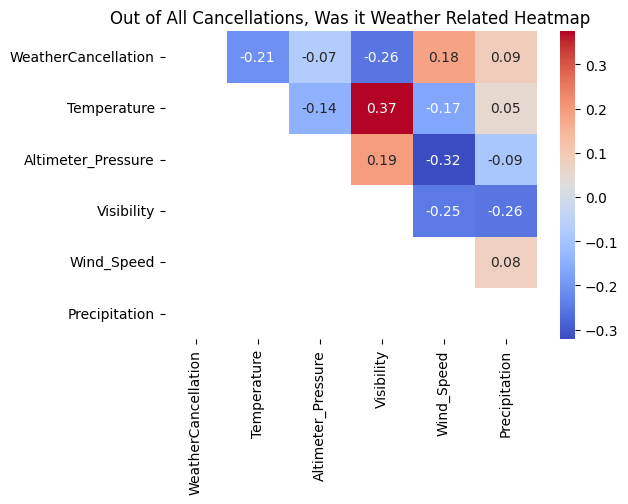

In [22]:
data = pd.read_csv('data/weather_cancellation_reason.csv')
data.drop(columns=['Time','Origin','Dest','Carrier','Cancelled','CancellationReason','CarrierDelay', 'Sea_Level_Pressure','SecurityDelay',
                   'LateAircraftDelay', 'Feels_Like_Temperature', 'Wind_Gust', 'Delayed', 'Ice_Accretion_3hr', 'WeatherDelay', 'NASDelay', 'DepDelayMinutes'], inplace=True)

columns_order = ['WeatherCancellation', 'Temperature', 'Altimeter_Pressure', 'Visibility', 'Wind_Speed', 'Precipitation']

data = data[columns_order]

correlation_matrix = data.corr()

mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Out of All Cancellations, Was it Weather Related Heatmap')
plt.show()

In [21]:
# 2. Preprocess your data
# Example: Handle missing values, encode categorical variables, etc.

# Assuming 'X' contains your features and 'y' contains your target variable
X = data[['Temperature', 'Feels_Like_Temperature', 'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed', 
          'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr',]]  # Include all your independent variables here
y = data['Cancelled']

# 3. Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 4. Choose a machine learning algorithm
model = LogisticRegression()

# 5. Train the model
model.fit(X_train, y_train)

# 6. Make predictions
y_pred = model.predict(X_test)

# 7. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 8. Tune hyperparameters (optional)
# Example: Use GridSearchCV or RandomizedSearchCV to find optimal hyperparameters

Accuracy: 0.9807170221109469
Classification Report:
              precision    recall  f1-score   support

       False       0.98      1.00      0.99    130060
        True       0.00      0.00      0.00      2544

    accuracy                           0.98    132604
   macro avg       0.49      0.50      0.50    132604
weighted avg       0.96      0.98      0.97    132604



c:\Users\wipar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
# Assuming X_train, X_test, y_train, y_test are your feature and target variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression with class weights and increased max_iter
model = LogisticRegression(class_weight={0: class_weights[0], 1: class_weights[1]}, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7223085276462249
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.73      0.84    130150
        True       0.04      0.53      0.07      2454

    accuracy                           0.72    132604
   macro avg       0.51      0.63      0.45    132604
weighted avg       0.97      0.72      0.82    132604



In [1]:
import joblib

# Final Model Testing

In [10]:
model = joblib.load("MIA/weather_delay_classification.pkl")

# X_test = [{"temp": 76.89, "pressure": 1008, "visibility": 10000, "wind_speed": 10.83, "rain": 0.083}]

X_test = [[82, 1015, 10000, 9.98, 0]]

# print(model.feature_names_in_ )
# predict_proba

print(model.predict(X_test))
print(model.predict_proba(X_test))

[ True]
[[0.39668293 0.60331707]]


c:\Users\wipar\SanJoseStateUniversity\DataMining\Project\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\wipar\SanJoseStateUniversity\DataMining\Project\.conda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
